# Medical Image Classification and Segmentation

The whole Pipeline is divided as follows:

- Register, approved for ADNI Dataset, extract corresponding data with labels from their Image collection in NIFTI file format
- Install Dependencies
- Data Extraction from NIFTI files
- EDA using demographics and history
- Extract labels for alzheimer's and vascular dementia
- Model Training
- Evaluation and visualize Results
- Image Segmentation using Voxelmorph
- 2D X-Ray Image classification for COVID-19


## Install Dependencies



```
Install MONAI and Voxelmorph
- Data Processing
- 3D Deep Neural Networks
- Probabilistic image segmentation
```



In [ ]:
!pip install monai

In [ ]:
!git clone -b redesign https://github.com/voxelmorph/voxelmorph.git

Cloning into 'voxelmorph'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 1639 (delta 1), reused 9 (delta 0), pack-reused 1619
Receiving objects: 100% (1639/1639), 128.82 MiB | 30.19 MiB/s, done.
Resolving deltas: 100% (979/979), done.


In [ ]:
# local imports.
import sys
sys.path.append('/content/voxelmorph/ext/pynd-lib/')
sys.path.append('/content/voxelmorph/ext/pytools-lib/')
sys.path.append('/content/voxelmorph/ext/neuron/')
sys.path.append('/content/voxelmorph')
import neuron
import voxelmorph as vxm

In [ ]:
!unzip '/drive/My Drive/MRI.zip'
!unzip '/content/voxelmorph.zip'
from google.colab import drive
drive.mount('/drive')

Archive:  /drive/My Drive/MRI.zip
replace ADNI/002_S_0295/B1-Calibration_Body/2006-04-18_08_37_26.0/S13400/ADNI_002_S_0295_MR_B1-Calibration_Body__br_raw_20060418200412613_1_S13400_I13710.nii? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Data Extraction

In [ ]:
import os
import sys
from glob import glob
import tempfile
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import torch
from torch.utils.data import DataLoader
from monai.transforms import \
    LoadNifti, LoadNiftid, AddChanneld,AsChannelFirst, ScaleIntensityRanged, \
    Rand3DElasticd, RandAffined, RandRotate,\
    Spacingd, Orientationd
import monai
from monai.data import NiftiDataset, GridPatchDataset, create_test_image_3d
from monai.transforms import Compose, AddChannel, Transpose, ScaleIntensity, ToTensor, RandSpatialCrop
from monai.transforms import Compose, AddChannel, ScaleIntensity, Resize, RandRotate90, ToTensor
import sys
import logging
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import monai
from monai.data import NiftiDataset

monai.config.print_config()

MONAI version: 0.1.0
Python version: 3.6.9 (default, Apr 18 2020, 01:56:04)  [GCC 8.4.0]
Numpy version: 1.18.4
Pytorch version: 1.5.0+cu101
Ignite version: 0.3.0


In [ ]:
# images = sorted(glob('/content/ADNI/002_S_*/Axial_*/*/*/*.nii'))

In [ ]:
images = sorted(glob('/content/ADNI/*_S_*/Sagittal_*/*/*/*.nii'))

In [ ]:
pd.read_csv('/drive/My Drive/AML/MODHACH.csv')

In [ ]:
modhach = pd.read_csv('/drive/My Drive/AML/MODHACH.csv', usecols=['RID', 'HMSCORE'])
demographics = pd.read_csv('/drive/My Drive/AML/PTDEMOG.csv', usecols=['RID', 'PTDOBYY'])

tellemore = pd.read_csv('/drive/My Drive/AML/TS_RATIO_ADJ.csv', usecols=['RID', 'TL_BP_ADJ'])
tellemore.head()

,RID,TL_BP_ADJ
0,2216,5551.38
1,4131,4849.63
2,4369,5054.77
3,4638,5025.51
4,1118,5289.10


In [ ]:
import plotly.express as px

In [ ]:
tellemore_length = modhach.merge(tellemore, on=['RID'])
tellemore_length['diagnosis'] = 'Normal'
tellemore_length.loc[(tellemore_length.HMSCORE > 2), 'diagnosis'] = 'Vascular Dementia'
tellemore_length.loc[(tellemore_length.HMSCORE.isin([1,2])), 'diagnosis'] = 'Alzheimers'

fig = px.box(tellemore_length, y="TL_BP_ADJ", x='diagnosis')
fig.update_layout(
    title={
        'text': "Telomere length  Distribution of AlzVascular Dementia Patients",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
      })

fig.show()

In [ ]:
demographics['current_year'] = 2006
demographics['age'] = demographics.current_year - demographics.PTDOBYY
demographics.head()

,RID,PTDOBYY,current_year,age
0,2,1931.0,2006,75.0
1,1,1944.0,2006,62.0
2,3,1924.0,2006,82.0
3,4,1938.0,2006,68.0
4,5,1931.0,2006,75.0


In [ ]:
check = modhach.merge(demographics, on=['RID'])

check['diagnosis'] = pd.np.NaN
check.loc[(check.HMSCORE > 2), 'diagnosis'] = 'Vascular Dementia'
check.loc[(check.HMSCORE.isin([1,2])), 'diagnosis'] = 'Alzheimers'

fig = px.box(check[~(check.diagnosis.isnull())], y="age", x='diagnosis')
fig.update_layout(
    title={
        'text': "Age Distribution of Alzheimers and Vascular Dementia Patients",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
      })

fig.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead



In [ ]:
rids = [int(im.split('/')[3].split('_')[-1]) for im in images]


### Extract and generate Labels and combine with Training Dataset.



In [ ]:
labels = [np.double(modhach[modhach.RID == rid].HMSCORE.values[0]) for rid in rids]
labels

In [ ]:
loader = LoadNifti(dtype=np.float32)
# image, metadata = loader('ADNI/002_S_0295/Axial_PD_T2_FSE/2006-04-18_08_38_08.0/S13404/ADNI_002_S_0295_MR_Axial_PD_T2_FSE__br_raw_20060418201014565_1_S13404_I13718.nii')

image, metadata = loader(images[4])

# print('input:', train_data_dicts[0]['image'])
print('image shape', image.shape)
print('image affine', metadata['affine'])
print('image pixdim', metadata['pixdim'])

image shape (160, 256, 256, 1)
image affine [[  1.19999695   0.           0.         103.27774811]
 [  0.           1.           0.         160.60025024]
 [  0.           0.           1.         397.49542236]
 [  0.           0.           0.           1.        ]]
image pixdim [  1.         1.199997   1.         1.       440.97885    0.
   0.         0.      ]


/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.199997 1.       1.       0.      ] to [  1.19999695   1.           1.         440.97884806]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))


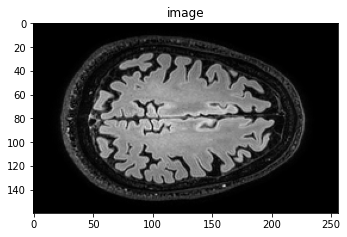

In [ ]:
# print('image shape: {}, label shape: {}'.format(image.shape, label.shape))
# plot the slice [:, :, 80]
plt.figure('check', (12, 6))
plt.subplot(1, 2, 1)
plt.title('image')
plt.imshow(image[:, :,180, 0], cmap='gray')
140
# plt.title('label')
# plt.imshow(label[:, :, 80])
plt.show()

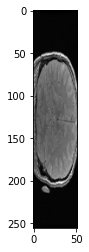

In [ ]:
plt.imshow(image[:, 98, :, 0], cmap='gray')

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
labels = [int(modhach[modhach.RID == rid].HMSCORE.values[0]) for rid in rids]
labels

In [ ]:
len(images), len(labels)

(89, 89)

### Train - Test Split and Add Transformations for Data Augmentation



In [ ]:
train_images, val_images, train_labels, val_labels = train_test_split(images, labels)

In [ ]:
labels = [int(modhach[modhach.RID == rid].HMSCORE.values[0]) for rid in rids]
labels

train_transforms = Compose([ScaleIntensity(), AsChannelFirst(),
                            RandRotate(degrees=15, prob=0.5), Resize((160, 160))
                            , ToTensor()])


# Define nifti dataset, data loader
check_ds = NiftiDataset(image_files=train_images, labels=train_labels, transform=train_transforms)
val_ds = NiftiDataset(image_files=val_images, labels=val_labels, transform=train_transforms)

check_loader = DataLoader(check_ds, batch_size=2, pin_memory=torch.cuda.is_available())
val_loader = DataLoader(val_ds, batch_size=2, pin_memory=torch.cuda.is_available())

In [ ]:
set(labels)

In [ ]:
np.array(labels[:3]).astype(np.float32)

array([4., 1., 1.], dtype=float32)

In [ ]:
len(images), len(labels)

(89, 89)

In [ ]:
# im, label = monai.utils.misc.first(check_loader)
# print(type(im), im.shape, label)


In [ ]:
im,label = monai.utils.misc.first(check_loader)
print(type(im), im.shape, label)

<class 'torch.Tensor'> torch.Size([1, 1, 160, 256, 256]) tensor([0])


/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.199997 1.       1.       0.      ] to [  1.19999695   1.           1.         438.35975894]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))


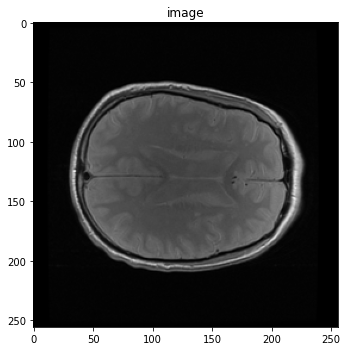

In [ ]:
# print('image shape: {}, label shape: {}'.format(image.shape, label.shape))
# plot the slice [:, :, 80]
plt.figure('check', (12, 6))
plt.subplot(1, 2, 1)
plt.title('image')
plt.imshow(imgR[:, :,20], cmap='gray')
140
# plt.title('label')
# plt.imshow(label[:, :, 80])
plt.show()

### Build Model and Train

In [ ]:
device = torch.device("cuda:0")

In [ ]:
model = monai.networks.nets.densenet.densenet121(spatial_dims=3, in_channels=1, out_channels=5,).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)


In [ ]:
from monai.metrics import compute_roc_auc

In [ ]:
# start a typical PyTorch training
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
writer = SummaryWriter()
for epoch in range(30):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{5}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in check_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(check_ds) // check_loader.batch_size
        print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            num_correct = 0.0
            metric_count = 0
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)

            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                val_outputs = model(val_images)
                value = torch.eq(val_outputs.argmax(dim=1), val_labels)
                metric_count += len(value)
                num_correct += value.sum().item()
                y_pred = torch.cat([y_pred, val_outputs], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            # auc_metric = compute_roc_auc(y_pred, y, to_onehot_y=True, add_softmax=True)
            metric = num_correct / metric_count
            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), "best_metric_model.pth")
                print("saved new best metric model")
            print(
                "current epoch: {} current accuracy: {:.4f} best accuracy: {:.4f} at epoch {}".format(
                    epoch + 1, metric, best_metric, best_metric_epoch
                )
            )
            writer.add_scalar("val_accuracy", metric, epoch + 1)
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
writer.close()



----------
epoch 1/5


/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.199997 1.       1.       0.      ] to [  1.19999695   1.           1.         436.59386123]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))
/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.2 1.  1.  0. ] to [  1.20000005   1.           1.         464.95325461]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))


1/33, train_loss: 1.5439


/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.199997 1.       1.       0.      ] to [  1.19999695   1.           1.         437.60199895]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))
/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.2 1.  1.  0. ] to [  1.20000005   1.           1.         445.56005553]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))


2/33, train_loss: 1.0095


/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.2 1.  1.  0. ] to [  1.20000005   1.           1.         441.40716093]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))
/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.2 1.  1.  0. ] to [  1.20000005   1.           1.         438.58858492]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))


3/33, train_loss: 1.1488


/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.2 1.  1.  0. ] to [  1.20000005   1.           1.         431.57856466]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))
/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.2 1.  1.  0. ] to [  1.20000005   1.           1.         447.3068171 ]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))


4/33, train_loss: 1.0240


/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.199997 1.       1.       0.      ] to [  1.19999695   1.           1.         440.97884806]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))
/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.2 1.  1.  0. ] to [  1.20000005   1.           1.         437.56299815]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))


5/33, train_loss: 1.1240


/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.199997 1.       1.       0.      ] to [  1.19999695   1.           1.         438.35975894]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))
/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.2 1.  1.  0. ] to [  1.20000005   1.           1.         468.26678981]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))


6/33, train_loss: 1.6039


/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.2 1.  1.  0. ] to [  1.20000005   1.           1.         443.80779844]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))
/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.199997 1.       1.       0.      ] to [  1.19999695   1.           1.         457.12681969]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))


7/33, train_loss: 1.0166


/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.2 1.  1.  0. ] to [  1.20000005   1.           1.         435.57861441]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))
/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.2 1.  1.  0. ] to [  1.20000005   1.           1.         447.90935817]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))


8/33, train_loss: 1.1738


/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.2 1.  1.  0. ] to [  1.20000005   1.           1.         436.81124707]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))
/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.199997 1.       1.       0.      ] to [  1.19999695   1.           1.         461.25496471]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))


9/33, train_loss: 1.0963


/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.2 1.  1.  0. ] to [  1.20000005   1.           1.         453.79262416]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))
/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.2 1.  1.  0. ] to [  1.20000005   1.           1.         463.68672168]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))


10/33, train_loss: 0.9510


/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.2000046 1.        1.        0.       ] to [  1.20000458   1.           1.         443.84449533]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))
/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.2000046 1.        1.        0.       ] to [  1.20000458   1.           1.         441.95865776]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))


11/33, train_loss: 1.1831


/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.199997 1.       1.       0.      ] to [  1.19999695   1.           1.         443.17936967]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))
/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.2 1.  1.  0. ] to [  1.20000005   1.           1.         441.16649157]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))


12/33, train_loss: 0.9971


/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.2 1.  1.  0. ] to [  1.20000005   1.           1.         448.30830742]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))
/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.2 1.  1.  0. ] to [  1.20000005   1.           1.         435.82939489]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))


13/33, train_loss: 1.6278


/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.199997 1.       1.       0.      ] to [  1.19999695   1.           1.         443.15560049]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))
/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.2 1.  1.  0. ] to [  1.20000005   1.           1.         443.78672958]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))


14/33, train_loss: 1.1576


/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.2 1.  1.  0. ] to [  1.20000005   1.           1.         438.02504372]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))
/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.199997 1.       1.       0.      ] to [  1.19999695   1.           1.         445.00615176]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))


15/33, train_loss: 1.4768


/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.2 1.  1.  0. ] to [  1.20000005   1.           1.         447.46786148]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))
/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.2 1.  1.  0. ] to [  1.20000005   1.           1.         435.04397075]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))


16/33, train_loss: 1.0823


/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.2000046 1.        1.        0.       ] to [  1.20000458   1.           1.         451.41410934]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))
/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.2 1.  1.  0. ] to [  1.20000005   1.           1.         454.78400326]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))


17/33, train_loss: 1.0192


/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.2 1.  1.  0. ] to [  1.20000005   1.           1.         438.35399036]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))
/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.2000046 1.        1.        0.       ] to [  1.20000458   1.           1.         456.38519998]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))


18/33, train_loss: 0.9615


/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.199997 1.       1.       0.      ] to [  1.19999695   1.           1.         442.27910445]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))
/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.199997 1.       1.       0.      ] to [  1.19999695   1.           1.         459.04077406]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))


19/33, train_loss: 0.9127


/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.2 1.  1.  0. ] to [  1.20000005   1.           1.         431.62163414]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))
/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.2 1.  1.  0. ] to [  1.20000005   1.           1.         442.38471699]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))


20/33, train_loss: 0.9966


/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.2 1.  1.  0. ] to [  1.20000005   1.           1.         454.71719139]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))
/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.2 1.  1.  0. ] to [  1.20000005   1.           1.         442.77574681]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))


21/33, train_loss: 0.9968


/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.2 1.  1.  0. ] to [  1.20000005   1.           1.         477.97107626]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))
/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.2 1.  1.  0. ] to [  1.20000005   1.           1.         446.93054469]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))


22/33, train_loss: 1.0073


/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.199997 1.       1.       0.      ] to [  1.19999695   1.           1.         452.93598883]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))
/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.2 1.  1.  0. ] to [  1.20000005   1.           1.         448.1113594 ]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))


23/33, train_loss: 1.0057


/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.199997 1.       1.       0.      ] to [  1.19999695   1.           1.         458.11776366]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))
/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.199997 1.       1.       0.      ] to [  1.19999695   1.           1.         448.60332122]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))


24/33, train_loss: 0.9896


/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.2 1.  1.  0. ] to [  1.20000005   1.           1.         433.90484388]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))
/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.2 1.  1.  0. ] to [  1.20000005   1.           1.         451.60333707]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))


25/33, train_loss: 0.8232


/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.199997 1.       1.       0.      ] to [  1.19999695   1.           1.         446.96541806]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))
/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.2 1.  1.  0. ] to [  1.20000005   1.           1.         446.35252488]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))


26/33, train_loss: 2.1500


/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.2 1.  1.  0. ] to [  1.20000005   1.           1.         436.08786668]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))
/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.2 1.  1.  0. ] to [  1.20000005   1.           1.         442.57908794]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))


27/33, train_loss: 1.1753


/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.199997 1.       1.       0.      ] to [  1.19999695   1.           1.         445.9098738 ]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))
/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.2 1.  1.  0. ] to [  1.20000005   1.           1.         462.71485953]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))


28/33, train_loss: 1.1716


/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.2 1.  1.  0. ] to [  1.20000005   1.           1.         477.67632882]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))
/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.2 1.  1.  0. ] to [  1.20000005   1.           1.         440.67208535]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))


29/33, train_loss: 1.6032


/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.2 1.  1.  0. ] to [  1.20000005   1.           1.         449.65827399]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))
/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.2 1.  1.  0. ] to [  1.20000005   1.           1.         434.97928287]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))


30/33, train_loss: 1.1777


/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.2 1.  1.  0. ] to [  1.20000005   1.           1.         434.91509873]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))
/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.2 1.  1.  0. ] to [  1.20000005   1.           1.         462.89162788]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))


31/33, train_loss: 1.4666


/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.2 1.  1.  0. ] to [  1.20000005   1.           1.         447.20743105]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))
/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.2 1.  1.  0. ] to [  1.20000005   1.           1.         448.24744078]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))


32/33, train_loss: 0.7680


/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.2 1.  1.  0. ] to [  1.20000005   1.           1.         438.32605566]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))
/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.199997 1.       1.       0.      ] to [  1.19999695   1.           1.         466.57500186]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))


33/33, train_loss: 0.9915
epoch 1 average loss: 1.1646
----------
epoch 2/5
1/33, train_loss: 1.3355
2/33, train_loss: 0.9816
3/33, train_loss: 1.1303
4/33, train_loss: 1.1377
5/33, train_loss: 1.2167
6/33, train_loss: 1.6707
7/33, train_loss: 0.9881
8/33, train_loss: 1.1270
9/33, train_loss: 0.9251
10/33, train_loss: 0.7644
11/33, train_loss: 1.1373
12/33, train_loss: 0.9625
13/33, train_loss: 1.6585
14/33, train_loss: 1.1232
15/33, train_loss: 1.5439
16/33, train_loss: 0.9126
17/33, train_loss: 0.9890
18/33, train_loss: 0.9348
19/33, train_loss: 0.8928
20/33, train_loss: 0.9802
21/33, train_loss: 0.9677
22/33, train_loss: 0.9860
23/33, train_loss: 0.9835
24/33, train_loss: 0.9639
25/33, train_loss: 0.7329
26/33, train_loss: 2.1560
27/33, train_loss: 1.1136
28/33, train_loss: 1.1149
29/33, train_loss: 1.5786
30/33, train_loss: 1.1397
31/33, train_loss: 1.4278
32/33, train_loss: 0.8064
33/33, train_loss: 0.8723
epoch 2 average loss: 1.1289


/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.199997 1.       1.       0.      ] to [  1.19999695   1.           1.         454.70433796]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))
/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.2 1.  1.  0. ] to [  1.20000005   1.           1.         456.32473495]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))
/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.199997 1.       1.       0.      ] to [  1.19999695   1.           1.         439.55148796]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))
/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.2 1.  1.  0. ] to [  1.20000005   1.           1.         448.33938491]
  warning

saved new best metric model
current epoch: 2 current accuracy: 0.5217 best accuracy: 0.5217 at epoch 2
----------
epoch 3/5
1/33, train_loss: 1.4071
2/33, train_loss: 0.9624
3/33, train_loss: 1.0989
4/33, train_loss: 1.0578
5/33, train_loss: 1.0959
6/33, train_loss: 1.6558
7/33, train_loss: 0.9659
8/33, train_loss: 1.0983
9/33, train_loss: 0.9623
10/33, train_loss: 0.6538
11/33, train_loss: 1.1151
12/33, train_loss: 0.9372
13/33, train_loss: 1.5104
14/33, train_loss: 1.0971
15/33, train_loss: 1.3662
16/33, train_loss: 0.9203
17/33, train_loss: 0.9652
18/33, train_loss: 0.9071
19/33, train_loss: 0.8081
20/33, train_loss: 0.9679
21/33, train_loss: 0.9589
22/33, train_loss: 0.9642
23/33, train_loss: 0.9605
24/33, train_loss: 0.9453
25/33, train_loss: 0.9509
26/33, train_loss: 2.2047
27/33, train_loss: 1.0762
28/33, train_loss: 1.0826
29/33, train_loss: 1.6245
30/33, train_loss: 1.0814
31/33, train_loss: 1.4166
32/33, train_loss: 0.6125
33/33, train_loss: 0.8099
epoch 3 average loss: 1.098

### Evaluation and  Results

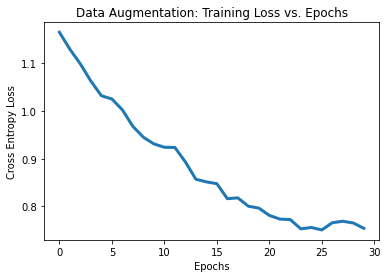

In [ ]:
plt.plot([i for i in range(len(epoch_loss_values))], [0 if e<0 else e for e in epoch_loss_values],
         linewidth=3)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.title('Data Augmentation: Training Loss vs. Epochs')

pass

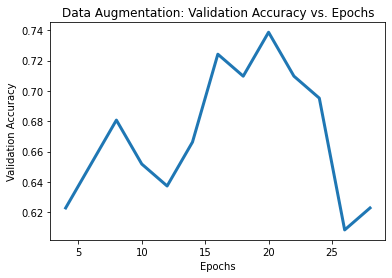

In [ ]:
df = pd.DataFrame({'epoch': [2*i for i in range(len(metric_values))], 'metric': metric_values})
rolling_mean = df.metric.rolling(window=3).mean()

plt.plot(df.epoch,rolling_mean, linewidth=3)
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Data Augmentation: Validation Accuracy vs. Epochs')

pass

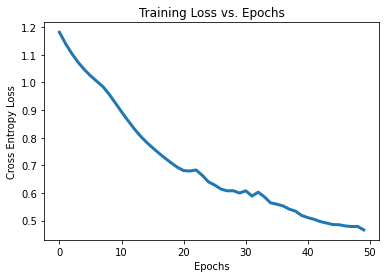

In [ ]:
plt.plot([i for i in range(len(epoch_loss_values))], [0 if e<0 else e for e in epoch_loss_values],
         linewidth=3)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.title('Training Loss vs. Epochs')

pass

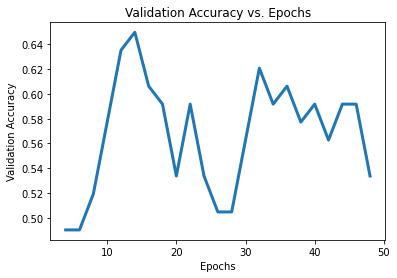

In [ ]:
df = pd.DataFrame({'epoch': [2*i for i in range(len(metric_values))], 'metric': metric_values})
rolling_mean = df.metric.rolling(window=3).mean()

plt.plot(df.epoch,rolling_mean, linewidth=3)
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. Epochs')

pass

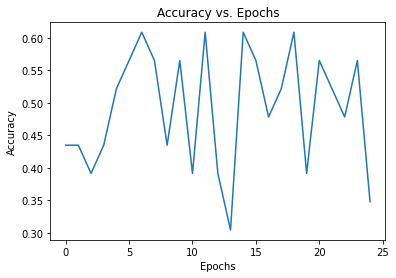

In [ ]:
plt.plot([i for i in range(len(metric_values))], [0 if e<0 else e for e in metric_values])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')

pass

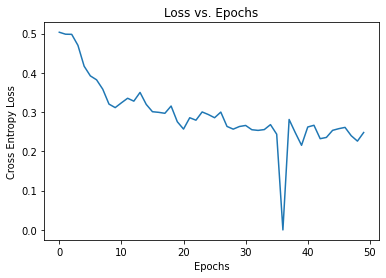

In [ ]:
plt.plot([i for i in range(len(epoch_loss_values))], [0 if e<0 else e for e in epoch_loss_values])
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss vs. Epochs')

pass

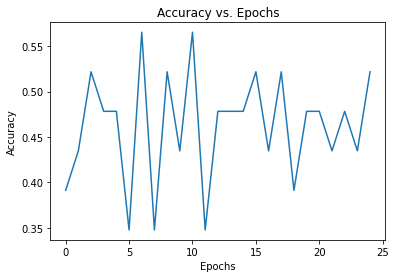

In [ ]:
plt.plot([i for i in range(len(metric_values))], [0 if e<0 else e for e in metric_values])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')

pass

In [ ]:
epoch_loss_values

In [ ]:
metric_values

[0.391304347826087,
 0.43478260869565216,
 0.5217391304347826,
 0.4782608695652174,
 0.4782608695652174,
 0.34782608695652173,
 0.5652173913043478,
 0.34782608695652173,
 0.5217391304347826,
 0.43478260869565216,
 0.5652173913043478,
 0.34782608695652173,
 0.4782608695652174,
 0.4782608695652174,
 0.4782608695652174,
 0.5217391304347826,
 0.43478260869565216,
 0.5217391304347826,
 0.391304347826087,
 0.4782608695652174,
 0.4782608695652174,
 0.43478260869565216,
 0.4782608695652174,
 0.43478260869565216,
 0.5217391304347826]

### Unsupervised Deep Learning for Bayesian MRI Segmentation  using Voxelmorph

In [ ]:
# our data will be of shape 160 x 192 x 224
vol_shape = [ 160, 256, 256]
ndims = 3

In [ ]:
nb_enc_features = [16, 32, 32, 32]
nb_dec_features = [32, 32, 32, 32, 32, 16, 16]

In [ ]:
import pandas as pd
import keras
dir(vxm)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'datagenerators',
 'losses',
 'networks']

In [ ]:
unet = vxm.networks.unet_core(vol_shape, nb_enc_features, nb_dec_features);
disp_tensor = keras.layers.Conv3D(ndims, kernel_size=3, padding='same', name='disp')(unet.output)

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()



Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
# spatial transfomer
spatial_transformer = neuron.layers.SpatialTransformer(name='image_warping')
moved_image_tensor = spatial_transformer([unet.inputs[0], disp_tensor])

# final model

vxm_model = keras.models.Model(unet.inputs, [moved_image_tensor, disp_tensor])

In [ ]:
!unzip '/Content/drive/My Drive/AML/3D_T2_MRI_Axial_Sagittal.zip'

unzip:  cannot find or open /Content/drive/My Drive/AML/3D_T2_MRI_Axial_Sagittal.zip, /Content/drive/My Drive/AML/3D_T2_MRI_Axial_Sagittal.zip.zip or /Content/drive/My Drive/AML/3D_T2_MRI_Axial_Sagittal.zip.ZIP.


In [ ]:
vxm_model.load_weights(
    '/drive/My Drive/AML/cvpr2018_vm2_cc.h5')


In [ ]:
!unzip '/drive/My Drive/AML/3D_T2_Axial_Sagittal_NFTI.zip'

In [ ]:
image[:]

In [ ]:
vxm_model.summary()

In [ ]:
image, metadata = loader(images[10])
# r = Resize((256, 32))
imgR = image#r(image[:,:,:,0])
imgR.shape

/usr/local/lib/python3.6/dist-packages/monai/data/utils.py:248: UserWarning: Modifying image pixdim from [1.199997 1.       1.       0.      ] to [  1.19999695   1.           1.         443.17936967]
  warnings.warn('Modifying image pixdim from {} to {}'.format(pixdim, norm))


(160, 256, 256, 1)

In [ ]:
val_pred = vxm_model.predict([imgR.reshape(-1, 160, 256, 256, 1), imgR.reshape(-1, 160, 256, 256, 1)])

In [ ]:
val_pred

In [ ]:
warp_model = vxm.networks.nn_trf(vol_shape)


In [ ]:
pred_warp = val_pred[1]

In [ ]:
warped_seg = warp_model.predict(
    [imgR.reshape(-1, 160, 256, 256, 1), pred_warp])

In [ ]:
from pytools import plotting as pytools_plot
import matplotlib

[ccmap, scrambled_cmap] = pytools_plot.jitter(255, nargout=2)
scrambled_cmap[0, :] = np.array([0, 0, 0, 1])
ccmap = matplotlib.colors.ListedColormap(scrambled_cmap)

In [ ]:
mid_slices_fixed = [np.take(imgR, vol_shape[d]//1.8, axis=d) for d in range(ndims)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_pred = [np.take(warped_seg.squeeze(), vol_shape[d]//1.8, axis=d) for d in range(ndims)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)

slices = mid_slices_fixed + mid_slices_pred
for si, slc  in enumerate(slices):
    slices[si][0] = 255



In [ ]:
 slices = [sl[:,:,0] if len(sl.shape) > 2 else sl for sl in slices]

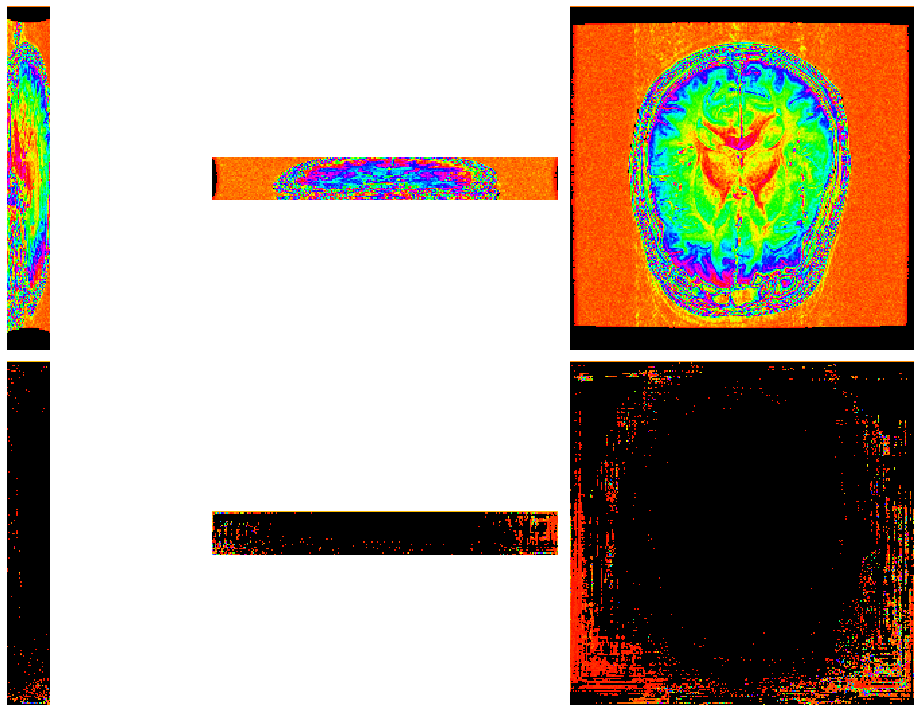

In [ ]:
mid_slices_fixed = [np.take(imgR, vol_shape[d]//1.8, axis=d) for d in range(ndims)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_pred = [np.take(warped_seg.squeeze(), vol_shape[d]//1.8, axis=d) for d in range(ndims)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)

slices = mid_slices_fixed + mid_slices_pred
for si, slc  in enumerate(slices):
    slices[si][0] = 255
neuron.plot.slices(slices, cmaps = [ccmap], grid=[2,3]);

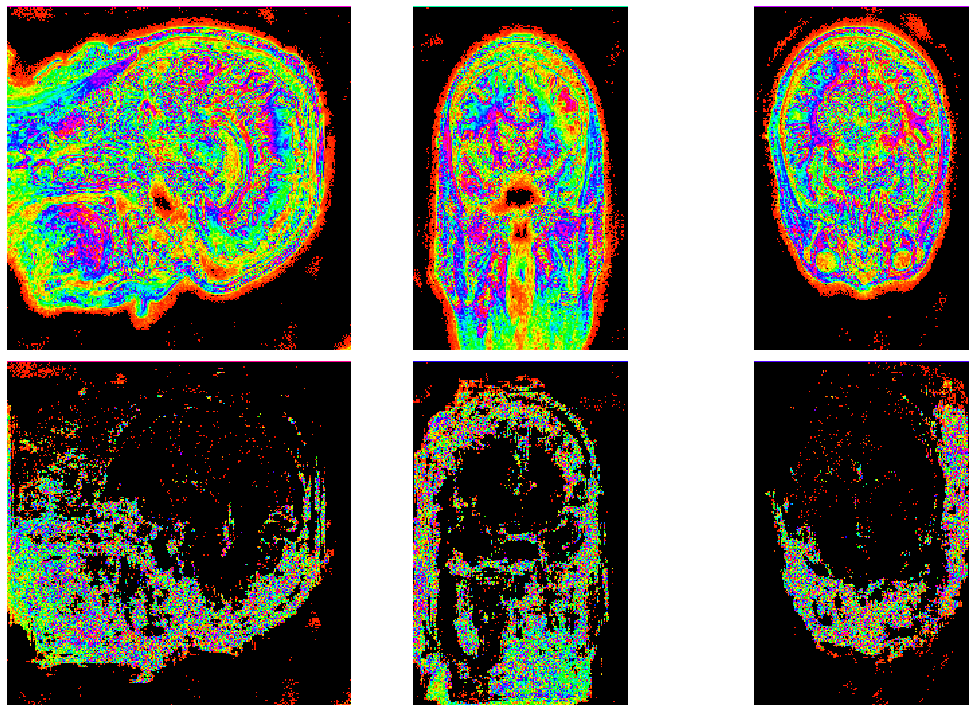

In [ ]:
neuron.plot.slices(slices, cmaps = [ccmap], grid=[2,3]);